In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Convolution2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D,ZeroPadding2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import pickle

## Restructure the folders

Before we can create a model for detecting gender, we need to restructor the folders to fit the flow_from_directory funtion.

#### Current Structure:

    ADAF
    ├── 18
    │   ├── 111       
    │   └── 112 
    ├── 19                        
    │   ├── 111       
    │   └── 112            
    └── ...
    
#### Desired Structure:

    ADAF
    ├── Male
    │   ├── 18
    │   ├── 19 
    │   └── ...
    └── Female                        
        ├── 18
        ├── 19 
        └── ...      

In [64]:
cp_command = 'cp -r '
for i in range(15,41):
    cp_command += str(i) +' '

In [65]:
# male folder
cp_male = cp_command + 'male' # copy all into the male folder
print(cp_male)
print("")
# delete female folders from male folder
rm_female_from_male = 'rm -rf '
for i in range(15,41):
    rm_female_from_male += str(i)+'/112 '
print(rm_female_from_male)

cp -r 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 male

rm -rf 15/112 16/112 17/112 18/112 19/112 20/112 21/112 22/112 23/112 24/112 25/112 26/112 27/112 28/112 29/112 30/112 31/112 32/112 33/112 34/112 35/112 36/112 37/112 38/112 39/112 40/112 


In [66]:
# female folder
cp_female = cp_command + 'female'  # copy all into the female folder
print(cp_female)
print("")
# delete female folders from male folder
rm_male_from_female = 'rm -rf '
for i in range(15,41):
    rm_male_from_female += str(i)+'/111 '
print(rm_male_from_female)

cp -r 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 female

rm -rf 15/111 16/111 17/111 18/111 19/111 20/111 21/111 22/111 23/111 24/111 25/111 26/111 27/111 28/111 29/111 30/111 31/111 32/111 33/111 34/111 35/111 36/111 37/111 38/111 39/111 40/111 


## Simple CNN Classifier

In [2]:
imggen = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1/255.0,validation_split=0.2)

batch_size=32
filepath = '/home/ubuntu/data/AFAD-Full/AFAD_gender'
train_datagen = imggen.flow_from_directory(filepath, target_size=(100,100),
                                           class_mode = 'binary',batch_size=batch_size,subset='training')
validation_datagen = imggen.flow_from_directory(filepath, target_size=(100,100),
                                            class_mode = 'binary',batch_size=batch_size, subset='validation')

Found 131535 images belonging to 2 classes.
Found 32883 images belonging to 2 classes.


In [3]:
gender_model = Sequential()

gender_model.add(Convolution2D(filters = 64, kernel_size = (3, 3),
        padding = 'same',input_shape=(100,100,3), activation = 'relu'))
gender_model.add(MaxPooling2D(pool_size= (2, 2)))
gender_model.add(Convolution2D(filters = 32, kernel_size = (3, 3), 
        padding = 'same', activation = 'relu'))
gender_model.add(MaxPooling2D(pool_size= (2, 2)))
gender_model.add(Dropout(rate = 0.5))
gender_model.add(Flatten())
gender_model.add(Dense(128, activation = 'relu'))
gender_model.add(Dropout(rate = 0.25))
gender_model.add(Dense(64, activation = 'relu'))
gender_model.add(Dropout(rate = 0.5))
gender_model.add(Dense(1, activation='sigmoid'))

gender_model.compile(optimizer='adam', 
        loss='binary_crossentropy', metrics=['accuracy'])

gender_model.summary()

W0422 22:48:41.933611 140619095844608 deprecation.py:506] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0422 22:48:42.239141 140619095844608 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 25, 25, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [4]:
checkpoint = ModelCheckpoint('gender_estimator.h5', monitor = 'val_loss', 
                             mode = 'min', save_best_only = True, verbose = 1)

earlystopping = EarlyStopping(monitor= 'val_loss', patience = 15, 
                              verbose = 1, restore_best_weights= True)

In [5]:
history_gender = gender_model.fit(train_datagen, batch_size=64, epochs=50, verbose=2,
                    validation_data=validation_datagen,callbacks=[earlystopping, checkpoint])

Epoch 1/50

Epoch 00001: val_loss improved from inf to 0.33202, saving model to gender_estimator.h5
4111/4111 - 261s - loss: 0.3747 - acc: 0.8348 - val_loss: 0.3320 - val_acc: 0.8511
Epoch 2/50

Epoch 00002: val_loss improved from 0.33202 to 0.27330, saving model to gender_estimator.h5
4111/4111 - 149s - loss: 0.3069 - acc: 0.8714 - val_loss: 0.2733 - val_acc: 0.8869
Epoch 3/50

Epoch 00003: val_loss improved from 0.27330 to 0.26491, saving model to gender_estimator.h5
4111/4111 - 148s - loss: 0.2836 - acc: 0.8825 - val_loss: 0.2649 - val_acc: 0.8906
Epoch 4/50

Epoch 00004: val_loss did not improve from 0.26491
4111/4111 - 149s - loss: 0.2708 - acc: 0.8895 - val_loss: 0.2721 - val_acc: 0.8853
Epoch 5/50

Epoch 00005: val_loss improved from 0.26491 to 0.23395, saving model to gender_estimator.h5
4111/4111 - 150s - loss: 0.2597 - acc: 0.8937 - val_loss: 0.2340 - val_acc: 0.9060
Epoch 6/50

Epoch 00006: val_loss did not improve from 0.23395
4111/4111 - 149s - loss: 0.2500 - acc: 0.8989 -

## Results Analysis

In [52]:
def graph_ACC(history,title):
    fig, ax = plt.subplots()
    ax.set_title(title)
    ax.plot(history.history['acc'], label='Train')
    ax.plot(history.history['val_acc'], label='Test')
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy")
    ax.legend()

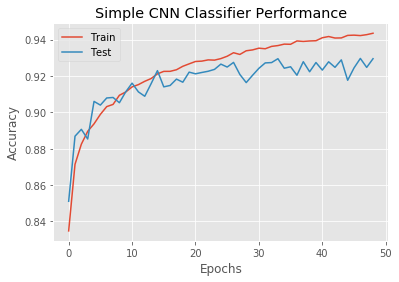

In [53]:
graph_ACC(history_gender, 'Simple CNN Classifier Performance')

In [17]:
y_true = np.array([])

for i in range(len(validation_datagen)):
    y_true = np.append(y_true, validation_datagen[i][1])

y_true.reshape(-1,1)

In [26]:
y_pred = gender_model.predict_classes(validation_datagen)

In [63]:
cm = confusion_matrix(y_true,y_pred, labels=[0,1])
cm

array([[11930,   804],
       [ 1515, 18634]])

Text(0.5, 1.0, 'Confusion Matrix - Simple CNN Classifier')

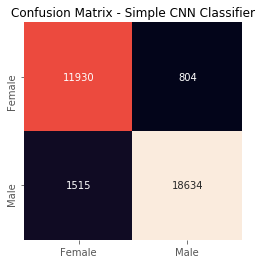

In [51]:
fig, ax = plt.subplots(figsize = (4,4))
categories = ['Female', 'Male']
sns.heatmap(cm, annot=True, fmt='', xticklabels= categories, yticklabels= categories, cbar=False, square=True, ax = ax)
ax.set_title('Confusion Matrix - Simple CNN Classifier', fontsize = 'large')

In [62]:
# save the history
with open('history_gender.pickle', 'wb') as f:
    pickle.dump(history_gender.history, f)